In [1]:
from gensim import corpora, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.stem.snowball import EnglishStemmer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
import time
import pandas as pd
import numpy as np
from nltk.stem import WordNetLemmatizer
import enchant
import re
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
import enchant
import re
from sklearn.neighbors import KNeighborsClassifier
from nltk.probability import FreqDist
from sklearn.svm import SVC
import fasttext
import tensorflow as tf

In [2]:
random_state=0
lemmatizer = WordNetLemmatizer()
eng_dic = enchant.Dict("en_US")

In [3]:
df = pd.read_json(path_or_buf='amazon_step1.json',orient='records',lines=True)
df.head()

,asin,category,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B000J4HXUC,Sports_and_Outdoors,"[1, 1]",5,It's a .50 Caliber Ammo Can. That largely sums...,"01 5, 2014",A3QRW0UJPKIAX7,Grant Fritchey,Clean and Exactly as Advertised,1388880000
1,0983393214,Books,"[0, 0]",5,This was a very good book. It kept me excited ...,"06 23, 2013",A2SEIOM4H06WTH,TJ,Great read!,1371945600
2,B003G4FVMY,Grocery_and_Gourmet_Food,"[0, 0]",5,"If you love coconut the way I do, you can't go...","05 19, 2013",A3GDEXMU9587JX,"K. Parsley ""kindlekat""","If you love coconut, get this coffee",1368921600
3,B00F9VRNF0,Cell_Phones_and_Accessories,"[0, 0]",5,I recently switched from the Galaxy S3 to the ...,"04 25, 2014",ASP3J2NEHDN4E,ChriS,Superior Protection!!!,1398384000
4,B00D5OZQUC,Amazon_Instant_Video,"[0, 0]",5,"Good show,looks like the gap from season 2 to ...","11 4, 2013",A1EDBI6TBKP9CO,Grants Book Trade,"Love the show, thanks for putting Season 3 on ...",1383523200


In [4]:
# Sampling to minimze computing cost
df = df.sample(5000,random_state=random_state)
df.head()

,asin,category,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
32311,B00109US84,Clothing_Shoes_and_Jewelry,"[0, 0]",5,I purchased this dress for my oldest daughter ...,"11 17, 2011",AFT0MSD3TM9CK,J. Leonard,"Great Dress, Great Price and Great Color",1321488000
90348,B000VJ7PC6,Beauty,"[0, 0]",5,Smelled this at Ulta and it is delicious. I pi...,"02 15, 2013",A1EMYTJKY3NA9F,oldfriends,Fuel For Life Homme,1360886400
19274,B001BOKGDU,Home_and_Kitchen,"[0, 0]",1,I never could make this coffeemaker produce de...,"06 6, 2013",ABXCC3A0JFQ8Q,carefulshopper,Made terrible coffee...,1370476800
62697,B005BYZAWI,Tools_and_Home_Improvement,"[0, 0]",4,"Not sure how long they last yet, but they seem...","11 21, 2013",A32UFI1Y91JUU1,"Scott C Jones ""HenryJonesJr""",Great buy.,1384992000
39787,B000FJYSHW,Patio_Lawn_and_Garden,"[0, 0]",5,I got one of these to replace a &#34;plastic&#...,"07 19, 2013",A2IX2PCXS5O2FK,Mike In San Diego,dihydrogen monoxide diverter!,1374192000


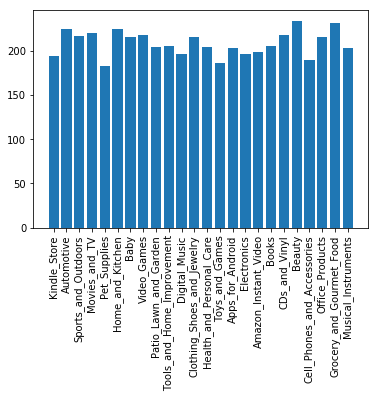

In [5]:
#Visualize if we have all categories
categories = set(df['category'])
category_occurence = []
categories_array = []
for category in categories:
    category_occurence.append(len(df[df['category']==category]))
    categories_array.append(category)

x = np.arange(1,25)
y = category_occurence

plt.bar(x, category_occurence)
plt.xticks(x, categories_array,rotation='vertical')
plt.show()

In [6]:
#Given a sentence return array of nouns only
def extract_set_nouns(sentence):
    data = pos_tag(word_tokenize(sentence), tagset='universal');
    
    worded_sentence = [i[0].lower() for i in data if (i[1] == 'NOUN') ]
    
    new_sentence = ""
    for word in set(worded_sentence):
        new_sentence += " " + word
    return (new_sentence)

#Given word return if it contains number or not
def hasNumbers(inputString):
    return bool(re.search(r'\d', inputString))


In [7]:
#Extract nouns only and make lowercase
reviewText_noun = [sentence.lower() for sentence in df['reviewText']]

reviewText_noun_no_special_character = []
reviewText_noun_no_special_character_no_english = []

#Remove special characters
for item in reviewText_noun:
    reviewText_noun_no_special_character.append(item.replace('\r',' ').replace('/n',' ').replace('.',' ').replace(',',' ').replace('(',' ')\
                                             .replace(')',' ').replace("'s",' ').replace('"',' ')\
                                             .replace('!',' ').replace('?',' ').replace("'",' ')\
                                             .replace('>',' ').replace('$',' ')\
                                             .replace('-',' ').replace(';',' ')\
                                             .replace(':',' ').replace('/',' ').replace('#',' '))


#Remove non english words and numbers and length less than 2 then lemmatize
reviewText_noun_no_special_character_no_english = [[lemmatizer.lemmatize(token) for token in comment.split() if ((eng_dic.check(token)) and (not hasNumbers(token)) and (len(token)>1)) ] 
                    for comment in reviewText_noun_no_special_character]
    
#Return to sentence format
seperated_comments = [' '.join(sentence) for sentence in reviewText_noun_no_special_character_no_english]

#Get only nouns once again. Some special characters and other factors messed the function in the first place
almost_ready_comments = [sentence for sentence in seperated_comments]


In [8]:
#Get most frequent words to add to stoplist if not found to be relevant
words = []
for token in almost_ready_comments:
    for word in token.split():
        words.append(word)

fdist = FreqDist(words)
top_n = fdist.most_common(100)

for word in top_n:
    print (word,"\n")

('the', 28452) 

('and', 16131) 

('to', 13799) 

('it', 13606) 

('of', 10101) 

('is', 9578) 

('this', 8140) 

('in', 6597) 

('for', 6314) 

('that', 6136) 

('you', 5281) 

('with', 4792) 

('on', 4563) 

('but', 4343) 

('my', 4323) 

('have', 3793) 

('a', 3605) 

('are', 3497) 

('not', 3383) 

('wa', 3363) 

('so', 2746) 

('one', 2738) 

('they', 2542) 

('be', 2448) 

('like', 2440) 

('can', 2169) 

('all', 2132) 

('if', 2089) 

('or', 1976) 

('just', 1959) 

('at', 1923) 

('very', 1886) 

('great', 1817) 

('from', 1787) 

('good', 1747) 

('out', 1728) 

('more', 1680) 

('up', 1676) 

('get', 1613) 

('ha', 1603) 

('when', 1587) 

('these', 1552) 

('will', 1538) 

('there', 1520) 

('time', 1503) 

('an', 1478) 

('would', 1476) 

('well', 1461) 

('them', 1414) 

('me', 1399) 

('use', 1381) 

('your', 1371) 

('game', 1310) 

('had', 1308) 

('some', 1281) 

('love', 1241) 

('about', 1233) 

('no', 1207) 

('what', 1196) 

('than', 1195) 

('really', 1192) 

('wo

In [9]:
#Manually updated the stopwords to add some that were not relevant
#Remove stopwords that we found to be not relevant in the previous part
stopword_file=open('stopwords_list_step1.txt')
stoplist=stopword_file.read().split()

#Still need to remove stopwords
ready_comments = [" ".join([token for token in comment.split() if (token not in stoplist) ]) for comment in almost_ready_comments]


In [10]:
#We will change the reviewText for all data. It doesn't matter if it's test or train
df['reviewText']=ready_comments
print (len(ready_comments))
df = df[df['reviewText'].map(len) > 1]
print (len(df['reviewText']))

5000
4999


In [11]:
# TODO better stoplist
# Current list :default english stopwords list from http://www.ranks.nl/stopwords
stopword_file=open('stopwords_list_step1.txt')
stoplist=stopword_file.read().split()
# configure CountVectorizer to include nltk-stemmer
stemmer = EnglishStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

# create vectorizer instance including the stop list and stemizer. 
# TODO modify max_df, min_df ?
stem_vectorizer = CountVectorizer(analyzer=stemmed_words,stop_words=stoplist,max_df=0.4,min_df=2,)

# fit vectorizer, carry out vectorization and display results
stem_vectorizer.fit(df['reviewText'])
documents_vec = stem_vectorizer.transform(df['reviewText'])
print(documents_vec) # sparse matrix representation
#print (stem_vectorizer)

  (0, 58)	1
  (0, 159)	1
  (0, 168)	2
  (0, 213)	2
  (0, 267)	1
  (0, 280)	1
  (0, 383)	1
  (0, 405)	1
  (0, 473)	1
  (0, 511)	1
  (0, 516)	1
  (0, 548)	1
  (0, 595)	1
  (0, 607)	1
  (0, 645)	1
  (0, 656)	1
  (0, 703)	1
  (0, 778)	1
  (0, 823)	1
  (0, 848)	1
  (0, 985)	1
  (0, 1024)	1
  (0, 1068)	1
  (0, 1075)	1
  (0, 1102)	1
  :	:
  (4998, 6038)	1
  (4998, 6078)	1
  (4998, 6087)	13
  (4998, 6112)	1
  (4998, 6128)	1
  (4998, 6236)	1
  (4998, 6237)	3
  (4998, 6247)	1
  (4998, 6289)	1
  (4998, 6308)	1
  (4998, 6366)	1
  (4998, 6384)	1
  (4998, 6446)	1
  (4998, 6495)	1
  (4998, 6513)	1
  (4998, 6634)	1
  (4998, 6663)	1
  (4998, 6687)	3
  (4998, 6753)	14
  (4998, 6775)	1
  (4998, 6827)	3
  (4998, 6889)	1
  (4998, 6925)	1
  (4998, 6976)	1
  (4998, 6986)	4


In [12]:
X=documents_vec.toarray()
y=df['category'].values.tolist()
categories=np.unique(y)
# Scaling the data
X_scaled=[]
for doc in X:
    min_max_scaler = preprocessing.MinMaxScaler()
    X_scaled.append(np.ravel(min_max_scaler.fit_transform(doc.reshape(-1, 1))))
    
vec_size = len(X_scaled[0])

/Users/fayezmourad/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [13]:
def vectorize_data(a):
    vec = np.zeros(24)
    vec[a] = 1
    return vec

categories = np.unique(y)
categories = np.ndarray.tolist(categories)
target_size = len(categories)

In [14]:
data = []
for element in df['category']:
    data.append(vectorize_data(categories.index(element)))

#print (data)
target = np.asarray(data)
print (target.shape)

(4999, 24)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, target, test_size=0.2, random_state=random_state)

In [16]:
X_train=np.array(X_train)
X_test=np.array(X_test)
y_train=np.array(y_train)
y_test=np.array(y_test)
print ("X train shape : ", X_train.shape)
print ("Y train shape : ",y_train.shape)
print ("X test shape : ", X_test.shape)
print ("Y test shape : ",y_test.shape)
boundary = X_train.shape[0]-100

X train shape :  (3999, 7023)
Y train shape :  (3999, 24)
X test shape :  (1000, 7023)
Y test shape :  (1000, 24)


In [17]:
# encoding: UTF-8
# Copyright 2016 Google.com
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
tf.set_random_seed(0)

# neural network with 1 layer of 10 softmax neurons

# input X: 1xvec_size vector
X_tensor = tf.placeholder(tf.float32, [None, vec_size])
# correct answers will go here
Y_ = tf.placeholder(tf.float32, [None, target_size])
# weights W[11119, 5]
W = tf.Variable(tf.zeros([vec_size, target_size]))
# biases b[5]
b = tf.Variable(tf.zeros([target_size]))


L = 200
M = 100
N = 60
O = 30
# Weights initialised with small random values between -0.2 and +0.2
# When using RELUs, make sure biases are initialised with small *positive* values for example 0.1 = tf.ones([K])/10
W1 = tf.Variable(tf.truncated_normal([vec_size, L], stddev=0.1))  # 784 = 28 * 28
B1 = tf.Variable(tf.zeros([L]))
W2 = tf.Variable(tf.truncated_normal([L, M], stddev=0.1))
B2 = tf.Variable(tf.zeros([M]))
W3 = tf.Variable(tf.truncated_normal([M, N], stddev=0.1))
B3 = tf.Variable(tf.zeros([N]))
W4 = tf.Variable(tf.truncated_normal([N, O], stddev=0.1))
B4 = tf.Variable(tf.zeros([O]))
W5 = tf.Variable(tf.truncated_normal([O, target_size], stddev=0.1))
B5 = tf.Variable(tf.zeros([target_size]))


Y1 = tf.nn.sigmoid(tf.matmul(X_tensor, W1) + B1)
Y2 = tf.nn.sigmoid(tf.matmul(Y1, W2) + B2)
Y3 = tf.nn.sigmoid(tf.matmul(Y2, W3) + B3)
Y4 = tf.nn.sigmoid(tf.matmul(Y3, W4) + B4)
Ylogits = tf.matmul(Y4, W5) + B5
Y = tf.nn.softmax(Ylogits)

#Define loss function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=Y_)
cross_entropy = tf.reduce_mean(cross_entropy)*100

# accuracy of the trained model, between 0 (worst) and 1 (best)
correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# training, learning rate = 0.005
learning_rate = 0.005
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

# matplotlib visualisation
allweights = tf.reshape(W, [-1])
allbiases = tf.reshape(b, [-1])

# init
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

max_test_accuracy = 0

#for i in range(0,boundary, 100):
batch_X = X_train
batch_Y = y_train
train_data = {X_tensor: batch_X, Y_: batch_Y}
print (batch_Y.shape)
# train
sess.run(train_step, feed_dict=train_data)

# success ?
a,c = sess.run([accuracy, cross_entropy], feed_dict=train_data)
print ("Train accuracy : ",a)
print ("Train cross entropy: ",c)

test_data={X_tensor: X_test, Y_: y_test}
a,c = sess.run([accuracy, cross_entropy], feed_dict=test_data)
max_test_accuracy = max(a,max_test_accuracy)
print ("Test accuracy : ",a)
print ("Test cross entropy: ",c)

    
    
print ("\n\n\n Max test accuracy : ", max_test_accuracy)

Tensorflow version 1.1.0
(3999, 24)
Train accuracy :  0.0462616
Train cross entropy:  318.164
Test accuracy :  0.039
Test cross entropy:  318.884



 Max test accuracy :  0.039
